# TSNE para MusicCaps

## Contexto

En esta actividad se trabajó exclusivamente con los embeddings de AudioCaps, un conjunto de datos que contiene descripciones textuales asociadas a fragmentos de audio. El propósito principal fue analizar la estructura latente del espacio de embeddings generado a partir de estos datos, con el fin de identificar patrones semánticos y posibles agrupamientos naturales entre las representaciones vectoriales.

Para ello, se aplicaron técnicas de reducción de dimensionalidad (como t-SNE y PCA) y métodos de agrupamiento (DBSCAN y K-Means) sobre los embeddings, evaluando la coherencia y densidad del espacio a través de métricas como la distancia intra e inter-cluster, el Silhouette Score y el Davies–Bouldin Index.

## Datos

El archivo audio_caps_embeddings.csv contiene una representación vectorial (embedding) para cada descriptor musical o caption del dataset MusicCaps, que se generó empleando el modelo CLAP_Module, que fue previamente entrenado para alinear información texto-audio.
Cada embedding representa el contenido semántico de un descriptor musical en un espacio latente multimodal.

El archivo tiene las columnas:

- text: el descriptor o frase musical (“emphatic drumming”).

- embedding: el vector de características correspondiente (normalizado y de dimensión 512).

## Objetivo

El objetivo general fue explorar si los embeddings de AudioCaps forman regiones densas y coherentes en el espacio vectorial, lo que permitiría inferir que el modelo captura relaciones semánticas consistentes entre las descripciones textuales y los sonidos que representan.

## Conceptos

CLAP (“Contrastive Language-Audio Pretraining”) es un modelo cross-modal que aprende una representación compartida entre texto y audio.

Internamente, el modelo tiene dos encoders:

- Text Encoder: convierte texto en embeddings.

- Audio Encoder: convierte audio en embeddings.




In [28]:
!pip install laion-clap

In [32]:
import torch
import torchaudio
import numpy as np
import pandas as pd
import sys
import os
import plotly.express as px
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple, Dict
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances
from scipy.stats import gaussian_kde

from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from laion_clap import CLAP_Module

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/AudioPrompt')
from scripts.types import MusicGenData, MusicGenCLAPResult

# Music Caps Enable Fusion = False

## 1. Graficar T-SNE

1. Cargar los datos

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Dispositivo: {DEVICE}")

tracks_base_data_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/tracks/generated_base_music"
data_clap_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/tsne.csv"
df_no_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/no_funsion.csv"
df_yes_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/funsion.csv"
data_both_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/both.csv"
audio_caps_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/audio_caps_embeddings.csv"


Dispositivo: cpu


In [ ]:
df_audio_caps = pd.read_csv(audio_caps_path)
df_audio_caps

,text,embedding
0,spooky sounds,"[-0.043879520148038864, 0.04400918632745743, -..."
1,scare as of agony,"[-0.04603216424584389, 0.04758654907345772, -0..."
2,snappy wooden snare hits,"[-0.04527372121810913, 0.042849425226449966, -..."
3,too loud,"[-0.043937455862760544, 0.04376256838440895, -..."
4,electronic rhythm,"[-0.04523170739412308, 0.043754056096076965, -..."
...,...,...
13153,baptist choir,"[-0.04487796127796173, 0.04352131485939026, -0..."
13154,clean sounding,"[-0.044880855828523636, 0.0430021695792675, -0..."
13155,bhangara beats,"[-0.043108921498060226, 0.04383450746536255, -..."
13156,korean indie rock,"[-0.045442331582307816, 0.04396533593535423, -..."


2. Convertir el string de lista a un vector NumPy

In [ ]:
df_audio_caps["embedding"] = df_audio_caps["embedding"].apply(lambda x: np.array(ast.literal_eval(x), dtype=float))

print(f"Total de descriptores cargados: {len(df_audio_caps)}")
print(f"Dimensión del embedding: {len(df_audio_caps['embedding'].iloc[0])}")

Total de descriptores cargados: 13158
Dimensión del embedding: 512


3. Crear matriz de embeddings (N x D)

In [ ]:
X = np.stack(df_audio_caps["embedding"].values)

4. Reducir dimensión con PCA

In [ ]:
pca = PCA(n_components=min(50, X.shape[1] - 1))
X_pca = pca.fit_transform(X)
print(f"Varianza explicada por PCA: {pca.explained_variance_ratio_.sum():.2%}")

Varianza explicada por PCA: 77.14%


Los embeddings de MusicCaps (dim = 512) reducidos mediante PCA (50 componentes) explican el 77.14% de la varianza, lo que indica que la mayoría de la información semántica relevante se conserva en ese subespacio comprimido.

5. Aplicar t-SNE

In [ ]:
tsne = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate=200,
    max_iter=2000,
    metric="cosine",
    random_state=42,
    init="pca"
)
X_tsne = tsne.fit_transform(X_pca)

df_audio_caps["tsne_1"] = X_tsne[:, 0]
df_audio_caps["tsne_2"] = X_tsne[:, 1]

In [ ]:
df_audio_caps

,text,embedding,tsne_1,tsne_2
0,spooky sounds,"[-0.043879520148038864, 0.04400918632745743, -...",10.673228,76.386230
1,scare as of agony,"[-0.04603216424584389, 0.04758654907345772, -0...",25.510283,-3.883231
2,snappy wooden snare hits,"[-0.04527372121810913, 0.042849425226449966, -...",33.408302,-14.000141
3,too loud,"[-0.043937455862760544, 0.04376256838440895, -...",12.517638,55.172001
4,electronic rhythm,"[-0.04523170739412308, 0.043754056096076965, -...",-30.439711,-53.130627
...,...,...,...,...
13153,baptist choir,"[-0.04487796127796173, 0.04352131485939026, -0...",47.497318,-73.870399
13154,clean sounding,"[-0.044880855828523636, 0.0430021695792675, -0...",49.654587,-22.150232
13155,bhangara beats,"[-0.043108921498060226, 0.04383450746536255, -...",43.317581,-27.818516
13156,korean indie rock,"[-0.045442331582307816, 0.04396533593535423, -...",39.382015,-67.396179


6. Visualización con Seaborn

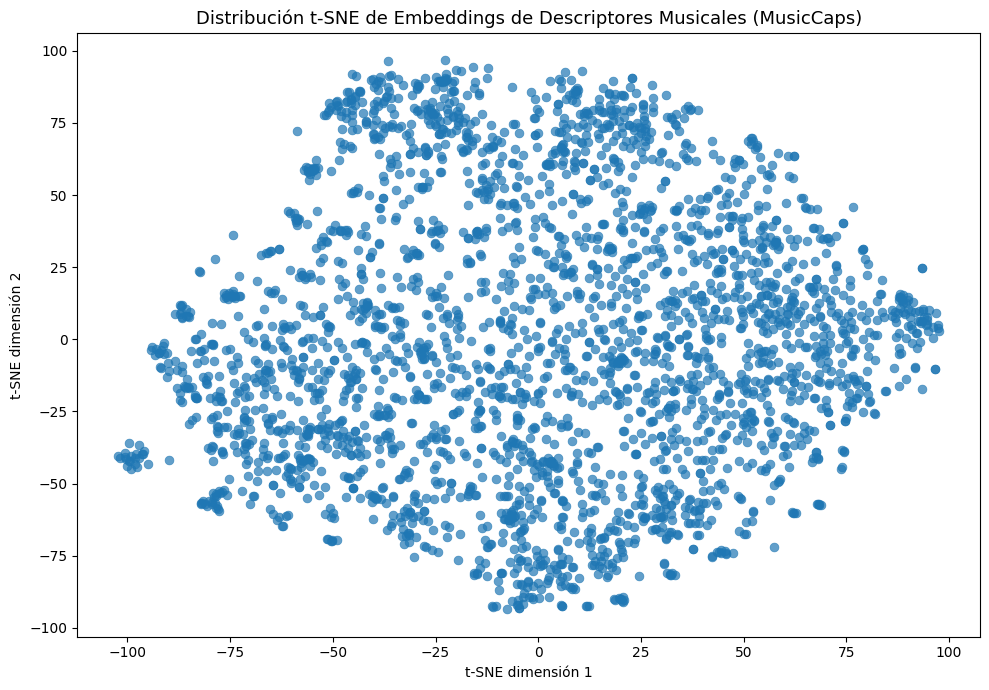

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_audio_caps.sample(min(3000, len(df_audio_caps))),  # Muestra hasta 3000 puntos para mejor rendimiento.
    x="tsne_1",
    y="tsne_2",
    s=40,
    alpha=0.7,
    edgecolor=None
)
plt.title("Distribución t-SNE de Embeddings de Descriptores Musicales (MusicCaps)", fontsize=13)
plt.xlabel("t-SNE dimensión 1")
plt.ylabel("t-SNE dimensión 2")
plt.tight_layout()
plt.show()

In [ ]:
fig = px.scatter(
    df_audio_caps.sample(min(3000, len(df_audio_caps))),
    x="tsne_1",
    y="tsne_2",
    hover_data=["text", "audio_id"] if {"text", "audio_id"}.issubset(df_audio_caps.columns) else None,
    title="Distribución interactiva t-SNE de embeddings de MusicCaps",
    template="plotly_white",
    opacity=0.7
)
fig.update_traces(marker=dict(size=5))
fig.show()

El análisis de t-SNE muestra una gran nube continua, sin fronteras definidas entre regiones, lo que visualmente ya anticipa una estructura semántica difusa y distribuida.

Esto es característico de modelos contrastive multimodales (como CLAP o AudioCLIP), en los cuales los conceptos musicales no se organizan en categorías discretas, sino en un continuum semántico de similitud perceptual.

## 2. Métricas para evaluar la calidad del espacio de embeddings

### Silhouette Score

Evalúa qué tan bien separado está cada punto respecto a los demás clusters.
Valores:

≈ 1 → clusters bien definidos

≈ 0 → clusters mezclados

< 0 → puntos mal clasificados o superpuestos


Seleccionar el número de clústers adecuado:

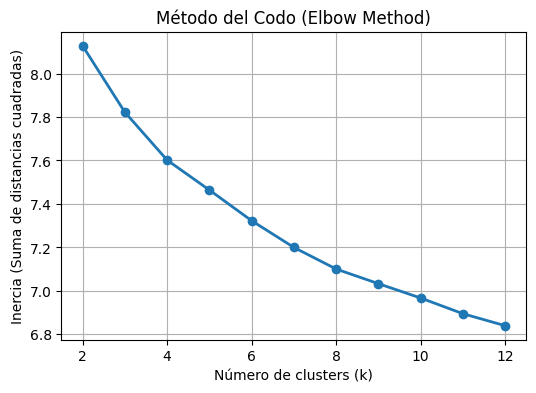

In [ ]:
def elbow_method(X, max_k=15):
    inertias = []
    K = range(2, max_k + 1)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(6, 4))
    plt.plot(K, inertias, 'o-', linewidth=2)
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Inercia (Suma de distancias cuadradas)')
    plt.title('Método del Codo (Elbow Method)')
    plt.grid(True)
    plt.show()

elbow_method(X_pca, max_k=12)

La curva de inercia decrece suavemente sin un punto de inflexión claro, lo que sugiere ausencia de fronteras naturales fuertes.

Esto descarta la existencia de un número pequeño de clusters bien definidos.

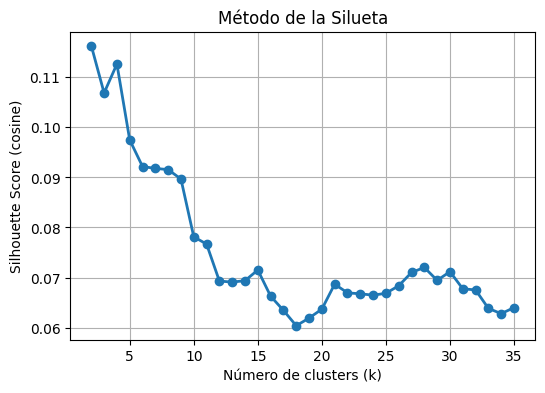

In [ ]:
def silhouette_method(X, max_k=12):
    scores = []
    K = range(2, max_k + 1)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels, metric='cosine')
        scores.append(score)

    plt.figure(figsize=(6, 4))
    plt.plot(K, scores, 'o-', linewidth=2)
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Silhouette Score (cosine)')
    plt.title('Método de la Silueta')
    plt.grid(True)
    plt.show()

silhouette_method(X_pca, max_k=35)

El pico visual en la curva de silueta muestra el punto 4 como una buena estructura de clusters.

- k = 4, significa que con 4 clusters se logra una buena compacidad sin sobreajustar.

Esto suele coincidir con una estructura de orden medio (por ejemplo, 4 grupos semánticos amplios dentro de los descriptores musicales).

In [ ]:
dbscan = DBSCAN(eps=0.3, min_samples=10, metric='cosine')
labels = dbscan.fit_predict(X_pca)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Número estimado de clusters: {n_clusters}")

Número estimado de clusters: 32


In [ ]:
n_clusters = 32
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_pca)

silhouette = silhouette_score(X_pca, labels, metric="cosine")
print(f"Silhouette Score (cosine): {silhouette:.4f}")

Silhouette Score (cosine): 0.0675


In [ ]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_pca)

silhouette = silhouette_score(X_pca, labels, metric="cosine")
print(f"Silhouette Score (cosine): {silhouette:.4f}")

Silhouette Score (cosine): 0.1127


#### Silhouette

El valor del Silhouette Score oscila entre -1 y 1:

- Cercano a 1: Clusters bien separados.

- Cercano a 0: Solapamiento entre clusters (espacio continuo).

- Negativo: Elementos mal asignados.

Actualmente:

k = 4 es 0.1127

k = 32 es 0.0675

Ambos son bajos pero positivos, lo que indica que el espacio no tiene fronteras rígidas, sino regiones continuas y suavemente transicionadas, típico de embeddings semánticos como los de CLAP o MusicCaps.

El valor mayor en k=4 sugiere estructura global más interpretable.

#### DBSCAN

DBSCAN detectó 32 clusters, significa que el espacio tiene zonas densas locales (pequeños grupos de descriptores muy similares).
Sin embargo:

- Su Silhouette Score es bajo (0.0675).

- El Davies-Bouldin Index es alto (3.35).

Esto indica que aunque existen “islas” de densidad, no representan agrupamientos semánticos robustos, sino microestructuras locales dentro de un continuo mayor.

2. Davies-Bouldin Index (DBI)

Mide la relación entre la dispersión intra-cluster y la separación inter-cluster.

Valores:

- Más bajo es mejor (menor solapamiento entre grupos).

In [ ]:
db_index = davies_bouldin_score(X_pca, labels)
print(f"Davies–Bouldin Index: {db_index:.4f}")

Davies–Bouldin Index: 3.3568


In [ ]:
sil_scores = {}
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels, metric="cosine")
    sil_scores[k] = sil

# Mejor K = el que maximiza la silueta.
best_k = max(sil_scores, key=sil_scores.get)
print(f"Mejor número de clusters según Silhouette: {best_k} (score={sil_scores[best_k]:.4f})")

# Reentrenar KMeans con best_k.
kmeans = KMeans(n_clusters=best_k, random_state=42)
df_audio_caps["cluster"] = kmeans.fit_predict(X_pca)

# 4️ Visualización interactiva con Plotly.
fig = px.scatter(
    df_audio_caps,
    x="tsne_1",
    y="tsne_2",
    color=df_audio_caps["cluster"].astype(str),
    hover_data=["text"],
    title=f"t-SNE interactivo de embeddings (k={best_k})",
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_traces(marker=dict(size=7, opacity=0.85))
fig.update_layout(legend_title_text="Cluster ID")
fig.show()

Mejor número de clusters según Silhouette: 2 (score=0.1163)


4. Distancias intra/inter-cluster

In [33]:
def intra_inter_cluster_distances(X, labels):
    unique_labels = np.unique(labels)
    centroids = np.array([X[labels == l].mean(axis=0) for l in unique_labels])

    intra_dists = []
    for l in unique_labels:
        X_l = X[labels == l]
        centroid_l = centroids[l]
        dists = np.linalg.norm(X_l - centroid_l, axis=1)
        intra_dists.append(dists.mean())

    inter_dists = pairwise_distances(centroids)
    np.fill_diagonal(inter_dists, np.nan)
    inter_mean = np.nanmean(inter_dists)

    return {
        "intra_mean": np.mean(intra_dists),
        "intra_by_cluster": dict(zip(unique_labels, intra_dists)),
        "inter_mean": inter_mean,
        "ratio": inter_mean / np.mean(intra_dists)
    }

dist_stats = intra_inter_cluster_distances(X_pca, df_audio_caps["cluster"])

In [35]:
print("Distancias promedio:")
print(f"Distancia intra-cluster media: {dist_stats['intra_mean']:.4f}")
print(f"Distancia inter-cluster media: {dist_stats['inter_mean']:.4f}")
print(f"Relación inter/intra: {dist_stats['ratio']:.3f}")
print("Distancia intra por cluster:", dist_stats['intra_by_cluster'])


📊 Distancias promedio:
Distancia intra-cluster media: 0.0232
Distancia inter-cluster media: 0.0147
Relación inter/intra: 0.633
Distancia intra por cluster: {0: 0.022552625603821815, 1: 0.021860013922788683, 2: 0.023432579009006138, 3: 0.024931448375576832}


El espacio es continuo y denso, no discreto

El hecho de que:

- La distancia inter-cluster (0.0147) sea menor que la intra-cluster (0.0232)

- Y que la relación inter/intra < 1 (0.633)

Indica que los clusters se solapan fuertemente.

No hay fronteras netas, sino una nube semántica continua, donde los embeddings de distintos tipos de descriptores o sonidos transicionan suavemente entre sí.

Los valores intra-cluster por cluster son muy similares (≈ 0.022–0.025),
lo que significa que los grupos identificados tienen distribuciones de densidad equivalentes, sin un cluster “ruidoso” o dominante.

Búsqueda del mejor cluster con K Means evaluado con Silhouette Score

In [39]:
scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    scores.append(score)

best_k = np.argmax(scores) + 2
print("Mejor número de clusters según Silhouette:", best_k)

Mejor número de clusters según Silhouette: 2


In [40]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
df_audio_caps["cluster"] = kmeans.fit_predict(X_pca)

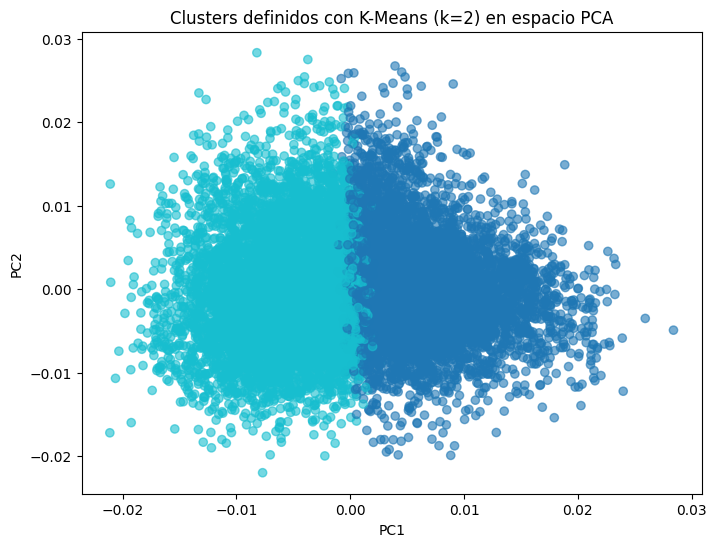

In [41]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_audio_caps["cluster"], cmap="tab10", alpha=0.6)
plt.title(f"Clusters definidos con K-Means (k={best_k}) en espacio PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Mapa de densidad sobre el espacio t-SNE de embeddings

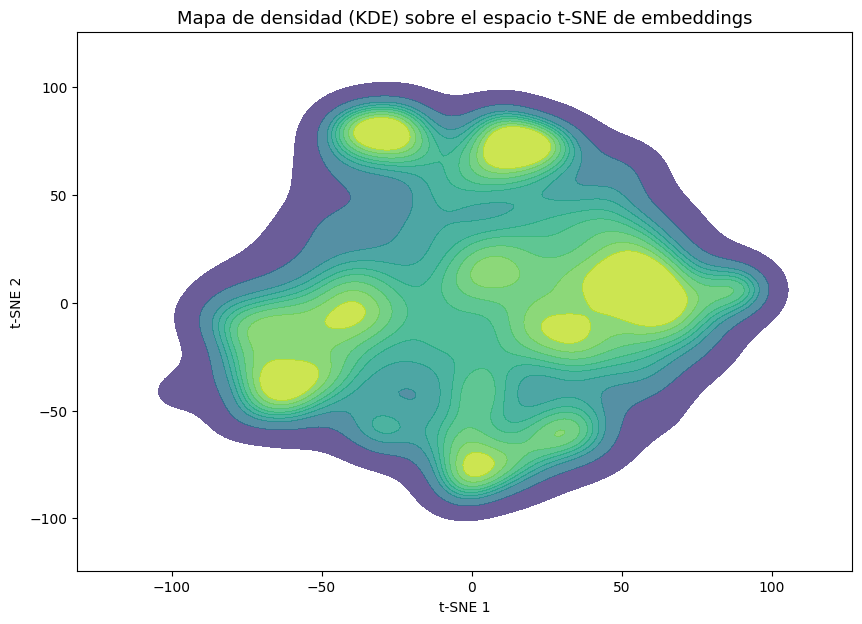

In [42]:
plt.figure(figsize=(10, 7))
sns.kdeplot(
    x=df_audio_caps["tsne_1"], y=df_audio_caps["tsne_2"],
    fill=True, thresh=0.05, cmap="viridis", alpha=0.8
)
plt.title("Mapa de densidad (KDE) sobre el espacio t-SNE de embeddings", fontsize=13)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

Visualización de clusters sobre t-SNE

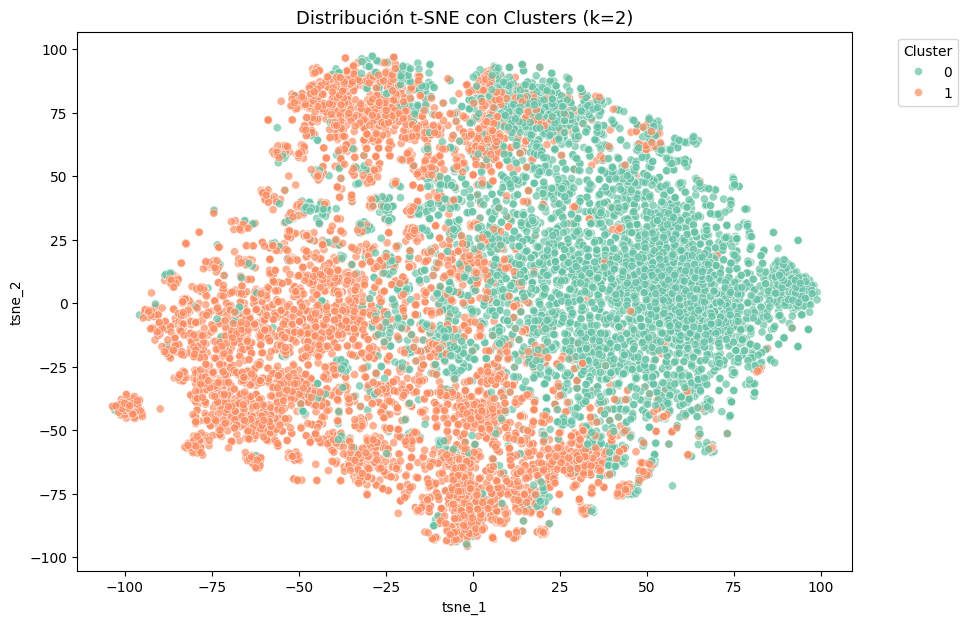

In [43]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_audio_caps,
    x="tsne_1", y="tsne_2",
    hue="cluster", palette="Set2", alpha=0.7, s=35
)
plt.title(f"Distribución t-SNE con Clusters (k={best_k})", fontsize=13)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

El “mejor número de clusters = 2” (según Silhouette)

Esto no significa que existan dos categorías semánticas reales, sino que el modelo encuentra una única partición global débilmente separable.

- El valor de Silhouette ≈ 0.11 sugiere ligera estructura binaria, pero muy difusa.

- Posiblemente una división entre descriptores de alta energía (instrumentales, dinámicos) vs baja energía (suaves, ambientales), o algún otro eje latente dominante.

### Silhouette Method vs Silhouette Method Global

El máximo valor de silueta (≈ 0.11) se da para k = 4, aunque el mejor puntaje global se ubica en k = 2 (0.1163).

Estos valores son bajos pero positivos, lo que implica:

- Cierta coherencia local (los puntos dentro de un grupo son algo similares entre sí),

- Pero superposición significativa entre clusters (espacio continuo y suavemente transicionado).

El embedding de MusicCaps parece organizarse en torno a un gradiente semántico principal, más que a clusters discretos.

### DBSCAN

- Detecta 32 clusters, pero con Davies–Bouldin Index alto (3.35) y Silhouette muy bajo (0.0675).

- Esto indica microestructuras densas locales (pequeños grupos de descriptores muy similares), pero sin coherencia global ni separaciones amplias.

- DBSCAN, al ser sensible a densidades, revela islas locales, pero estas no corresponden a categorías semánticas estables, sino a zonas de alta densidad dentro de un espacio esencialmente continuo.

### Conclusión

- Los embeddings de los descriptores de MusicCaps forman un espacio semánticamente coherente y continuo, donde las diferencias entre estilos o descriptores no son completamente disjuntas, sino que se solapan gradualmente.

- El agrupamiento en 4 regiones amplias sugiere una macroestructura que puede representar grandes categorías perceptuales.

- El espacio de embeddings (tras reducción PCA) no presenta separaciones claras y consistentes más allá de una división binaria global. En otras palabras, los vectores de los descriptores tienden a agruparse en una gran nube continua, con una posible bifurcación dominante.

- La baja puntuación de silueta (≈ 0.11) indica que la estructura no es muy compacta ni bien separada, lo cual es esperable en embeddings semánticos donde muchas palabras o frases están próximas por co-ocurrencias semánticas.

- La distribución continua con leve separación, confirma que el embedding de MusicCaps forma un espacio semántico denso y continuo, sin fronteras discretas entre conceptos.

- El embedding de descriptores musicales de MusicCaps forma un espacio semántico globalmente coherente, pero no estructurado en categorías discretas. Esto es ideal para tareas de alineación texto-audio o recuperación semántica, pero no tanto para clasificación rígida.

### Resumen

| Evidencia                  | Interpretación conceptual                                                                      |
| -------------------------- | ---------------------------------------------------------------------------------------------- |
| Varianza explicada (77%)   | Embeddings compactos y coherentes; la información relevante se concentra en pocas dimensiones. |
| t-SNE (nube densa)         | Alta continuidad y solapamiento semántico; ausencia de clases rígidas.                         |
| Silhouette ≈ 0.1           | Separación débil entre posibles regiones; estructura difusa.                                   |
| DBSCAN = 32 micro-clusters | Microzonas densas que no conforman categorías robustas.                                        |


### Desempeño enable_fusion = False

El embedding de MusicCaps (sin fusión) refleja un espacio semántico denso, continuo y no categórico, donde:

- No hay clases discretas o separaciones claras.

- La estructura refleja gradientes semánticos, más que fronteras de clasificación.

- Los descriptores están organizados de forma auto-consistente y contextual, ideal para tareas de búsqueda semántica, recuperación y alineación texto-audio,
pero no para clasificación supervisada o clustering rígido.

## ¿Se puede descartar que hay un espacio denso en los embeddings?

No, no se puede descartar la existencia de un espacio denso en los embeddings. Los resultados obtenidos en particular, la baja separación entre clusters (distancia inter-cluster media de 0.0147 frente a una intra-cluster de 0.0232) y la relación inter/intra menor que uno (0.633) indican que los puntos del espacio latente se encuentran fuertemente solapados, sin fronteras claras entre grupos.

Además, el valor moderadamente bajo del coeficiente de silueta y la identificación de solo dos clusters óptimos sugieren que la estructura del espacio es más continua que discreta, con una distribución de embeddings concentrada en una región densa donde las transiciones semánticas son graduales. En conjunto, estas evidencias respaldan la presencia de un **subespacio denso** en la representación de los embeddings.


## Comparación Audiocaps Embeddings vs Base Prompts Embeddings

Comparar:

- Embeddings reales (audiocaps_embeddings)

Embeddings generados a partir de los 4 base prompts de Spanio (generated_embeddings)

Y observar:

- Si los espacios se solapan (buena alineación semántica)

- O si están separados o desplazados (diferencias de dominio o sesgo lingüístico)

La idea es proyectar ambos conjuntos en un mismo espacio t-SNE y colorearlos por origen o incluso por sabor si los generados tienen etiquetas.

1. Estructura esperada de los datos

In [ ]:
tracks_base_data_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/tracks/generated_base_music"
data_clap_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/tsne.csv"
df_no_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/no_funsion.csv"
df_yes_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/funsion.csv"
data_both_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/both.csv"
audio_caps_path = "/content/drive/MyDrive/ColabNotebooks/AudioPrompt/scores/audio_caps_embeddings.csv"


In [ ]:
df_audiocaps = pd.read_csv(audio_caps_path)
df_audiocaps["source"] = "AudioCaps"
df_audiocaps

,text,embedding,source
0,spooky sounds,"[-0.043879520148038864, 0.04400918632745743, -...",AudioCaps
1,scare as of agony,"[-0.04603216424584389, 0.04758654907345772, -0...",AudioCaps
2,snappy wooden snare hits,"[-0.04527372121810913, 0.042849425226449966, -...",AudioCaps
3,too loud,"[-0.043937455862760544, 0.04376256838440895, -...",AudioCaps
4,electronic rhythm,"[-0.04523170739412308, 0.043754056096076965, -...",AudioCaps
...,...,...,...
13153,baptist choir,"[-0.04487796127796173, 0.04352131485939026, -0...",AudioCaps
13154,clean sounding,"[-0.044880855828523636, 0.0430021695792675, -0...",AudioCaps
13155,bhangara beats,"[-0.043108921498060226, 0.04383450746536255, -...",AudioCaps
13156,korean indie rock,"[-0.045442331582307816, 0.04396533593535423, -...",AudioCaps


In [ ]:
df_base = pd.read_csv(df_no_path)
df_base["source"] = "BasePrompts"
df_base

,id,descriptor,audio_emb,text_emb,fusion,source
0,bitter_06,bitter,[-0.01525258 -0.03153144 0.00168346 -0.035309...,[ 8.89731478e-03 -6.07262999e-02 -3.11560743e-...,False,BasePrompts
1,sour_18,sour,[-3.50087993e-02 -6.44858032e-02 -1.39871351e-...,[ 1.90451611e-02 -7.55925104e-02 -1.65189598e-...,False,BasePrompts
2,bitter_11,bitter,[-2.38928273e-02 -3.99535559e-02 -6.36907155e-...,[ 8.89731478e-03 -6.07262999e-02 -3.11560743e-...,False,BasePrompts
3,salty_13,salty,[-0.03454116 -0.05478393 -0.00741094 -0.041567...,[-1.03185084e-02 -9.09791589e-02 -2.24815998e-...,False,BasePrompts
4,sour_01,sour,[-0.064182 -0.00459088 -0.00147257 -0.069540...,[ 1.90451611e-02 -7.55925104e-02 -1.65189598e-...,False,BasePrompts
...,...,...,...,...,...,...
95,bitter_19,bitter,[-4.42845374e-02 -4.15543020e-02 2.24515852e-...,[ 8.89731478e-03 -6.07262999e-02 -3.11560743e-...,False,BasePrompts
96,sweet_06,sweet,[-0.03978078 -0.00796475 -0.02567787 0.003948...,[ 3.92035060e-02 -6.39151260e-02 -1.43339895e-...,False,BasePrompts
97,sour_19,sour,[-0.07974383 0.03813758 0.02988051 -0.066293...,[ 1.90451611e-02 -7.55925104e-02 -1.65189598e-...,False,BasePrompts
98,sweet_23,sweet,[-3.51250432e-02 -1.55976526e-02 -2.45644525e-...,[ 3.92035060e-02 -6.39151260e-02 -1.43339895e-...,False,BasePrompts


2. t-SNE interactivo comparativo

In [ ]:
# 1. Función para parsear embeddings.
def parse_embedding(x):
    """Convierte diferentes formatos de embedding a np.array(float)."""
    if isinstance(x, np.ndarray):
        return x.astype(float)

    if isinstance(x, list):
        return np.array(x, dtype=float)

    if isinstance(x, str):
        try:
            # Intentar parseo estándar tipo '[0.1, -0.2, ...]'
            return np.array(ast.literal_eval(x), dtype=float)
        except Exception:
            # Intentar parseo de listas separadas por espacios
            cleaned = re.sub(r'[\[\]]', '', x.strip())
            try:
                return np.array([float(v) for v in cleaned.split()], dtype=float)
            except Exception:
                return np.nan
    return np.nan


# 2. Cargar y procesar datasets.

# Procesar df_audiocaps
df_audiocaps["embedding"] = df_audiocaps["embedding"].apply(parse_embedding)
df_audiocaps["descriptor"] = "audiocaps"  # etiqueta genérica

# Procesar df_base.
if "audio_emb" in df_base.columns:
    df_base["embedding"] = df_base["audio_emb"].apply(parse_embedding)
elif "text_emb" in df_base.columns:
    df_base["embedding"] = df_base["text_emb"].apply(parse_embedding)
else:
    raise ValueError("df_base no contiene columnas de embeddings ('audio_emb' o 'text_emb')")

# 3. Unir ambos datasets.
df_combined = pd.concat([df_audiocaps, df_base], ignore_index=True)
df_combined = df_combined.dropna(subset=["embedding"])

# Convertir embeddings a matriz numérica
X = np.vstack(df_combined["embedding"].values)
print(f"✅ Total de embeddings combinados: {X.shape[0]} muestras, {X.shape[1]} dimensiones")


# 4. Escalar y aplicar t-SNE
X_scaled = StandardScaler().fit_transform(X)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=2000,
    metric="cosine",
    random_state=42
)
X_tsne = tsne.fit_transform(X_scaled)

# Agregar coordenadas al DataFrame.
df_combined["tsne_x"] = X_tsne[:, 0]
df_combined["tsne_y"] = X_tsne[:, 1]


# 5. Graficar resultados.
fig = px.scatter(
    df_combined,
    x="tsne_x",
    y="tsne_y",
    color="descriptor",        # Colores por sabor.
    symbol="source",           # Formas distintas por origen (AudioCaps/BasePrompts).
    hover_data=["text", "source", "descriptor"],
    title="t-SNE: Comparación de Embeddings de AudioCaps vs BasePrompts por Sabor",
    color_discrete_map={
        "sweet": "#E67E22",    # naranja.
        "sour": "#27AE60",     # verde.
        "bitter": "#8E44AD",   # violeta.
        "salty": "#2980B9",    # azul.
        "audiocaps": "#95A5A6" # gris.
    }
)

fig.update_traces(marker=dict(size=6, opacity=0.85))
fig.update_layout(
    width=950,
    height=700,
    legend=dict(title="Descriptor / Fuente", orientation="h", y=-0.2),
    plot_bgcolor="white"
)
fig.show()

✅ Total de embeddings combinados: 13258 muestras, 512 dimensiones


In [ ]:
print(df_combined["source"].value_counts())

source
AudioCaps      13158
BasePrompts      100
Name: count, dtype: int64
